# Image classification

## Setup

Import TensorFlow and other necessary libraries:

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

Preprocessing - convert image format to jpg

In [19]:
import pathlib
from PIL import Image

# Set up input and output directories
input_directory = pathlib.Path('data/my_data/').with_suffix('')
output_directory = pathlib.Path('data/converted_data/').with_suffix('')

# Ensure the input directory exists
if not input_directory.is_dir():
    print(f"The directory {input_directory} does not exist.")
else:
    # Ensure the output directory exists or create it
    output_directory.mkdir(parents=True, exist_ok=True)

    # Iterate through all image files in the directory and its subdirectories
    for image_path in input_directory.rglob('*.*'):
        if image_path.suffix.lower() in ['.jpeg', '.jpg', '.JPG', '.png', '.bmp', '.gif', '.tiff', '.webp']:  # Add more formats if needed
            try:
                # Define the output path with .jpg extension in the output directory
                relative_path = image_path.relative_to(input_directory)
                output_path = output_directory / relative_path.with_suffix('.jpg')

                # Ensure the output subdirectory exists
                output_path.parent.mkdir(parents=True, exist_ok=True)

                # Open the image
                with Image.open(image_path) as img:
                    # Convert the image to RGB mode (necessary for saving as JPG)
                    rgb_image = img.convert('RGB')

                    # Save the image as JPG
                    rgb_image.save(output_path, format='JPEG')
            
            except Exception as e:
                print(f"Failed to convert {image_path}: {e}")


c:\Users\alfns\Documents\College\SemesterVI\MachineLearning\Lab\Project\machine\venv\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (117981640 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [20]:
data_new = pathlib.Path('data/converted_data/').with_suffix('')
image_count = len(list(data_new.glob('*/*.jpg')))
print(f"Counte Image: {image_count}")

Counte Image: 3403


### Create a dataset

Use 80% of the images for training and 20% for validation.

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_new,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 3403 files belonging to 20 classes.
Using 2723 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_new,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 3403 files belonging to 20 classes.
Using 680 files for validation.


In [23]:
class_names = train_ds.class_names
print(class_names)

['Apple', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Carambola', 'Cherry', 'Fig', 'Grape', 'Kiwi', 'Lemon', 'Lychee', 'Mango', 'Orange', 'Papaya', 'Pear', 'Pineapple', 'Raspberry', 'Strawberry', 'Watermelon']


## Visualize the data

Here are the first nine images from the training dataset:

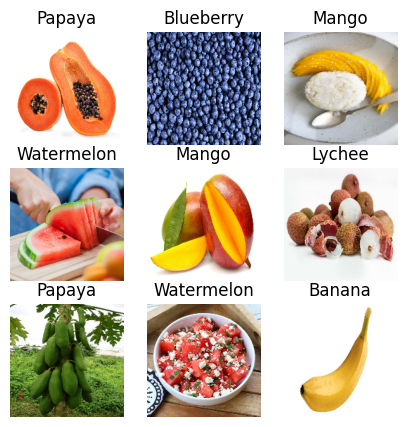

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Iterate over the dataset and retrieve batches of images:

In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Configure the dataset for performance

Use buffered prefetching to yield data from disk without having I/O become blocking

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create model

In [27]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,991,220 (15.23 MB)

 Trainable params: 3,991,220 (15.23 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [30]:
classify = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.0866 - loss: 3.0082 - val_accuracy: 0.2221 - val_loss: 2.5924
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.2389 - loss: 2.3723 - val_accuracy: 0.2265 - val_loss: 2.3698
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.3342 - loss: 2.0798 - val_accuracy: 0.2676 - val_loss: 2.2795
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.4538 - loss: 1.7216 - val_accuracy: 0.2897 - val_loss: 2.2980
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.5838 - loss: 1.3214 - val_accuracy: 0.3118 - val_loss: 2.5470
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7494 - loss: 0.8108 - val_accuracy: 0.3088 - val_loss: 3.1946
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8568 - loss: 0.4871 - val_accuracy: 0.3515 - val_loss: 3.5111
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9067 - loss: 0.3087 - val_accuracy: 0.3235 - 

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

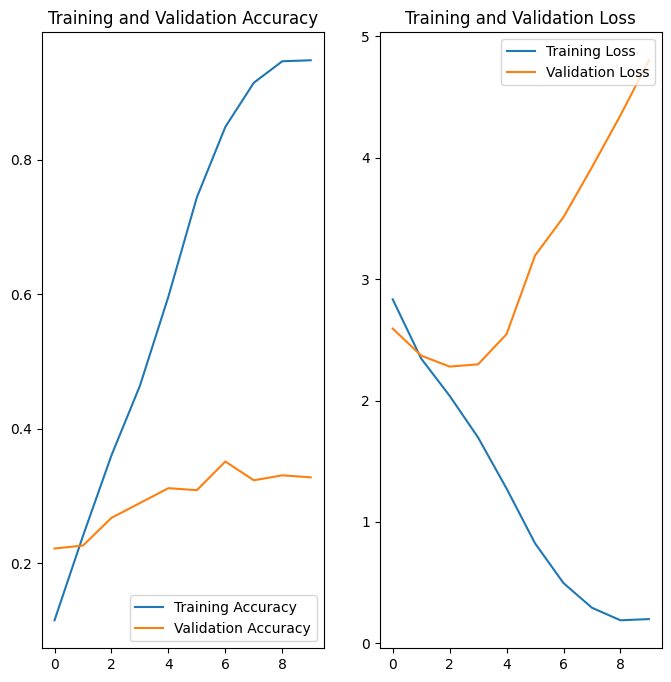

In [31]:
acc = classify.history['accuracy']
val_acc = classify.history['val_accuracy']

loss = classify.history['loss']
val_loss = classify.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
inference_img_path = "apple.jpg"

img = tf.keras.utils.load_img(
    inference_img_path, target_size=(180, 180)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to Lychee with a 99.57 percent confidence.


In [35]:
model.save('models/classify_fruit_model.h5')
model.save('models/classify_fruit_model.keras')

In [34]:
model.save('../backend/models/classify_fruit_model.h5')
model.save('../backend/models/classify_fruit_model.keras')